# Lab 2 : Generative Models (Generative adversarial networks)
```
- [S24] Advanced Machine Learning, Innopolis University
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
Lab Plan
1. Conditional Generative adversarial networks
2. Bidirectional Generative Adversarial Network
3. Task 2
```

<hr>

## 1. Conditional Generative adversarial network


The Conditional Generative Adversarial Network (cGAN) is a model used in deep learning, a derivative of machine learning. It enables more precise generation and discrimination of data. The achitecture is similar to the one of vanilla GAN.


The condition for data generation is a link to the label of the data.

![Conditional GAN](https://www.researchgate.net/profile/Gerasimos-Spanakis/publication/330474693/figure/fig1/AS:956606955139072@1605084279074/GAN-conditional-GAN-CGAN-and-auxiliary-classifier-GAN-ACGAN-architectures-where-x_Q320.jpg)

### Imports

`!pip install tensorboardX`

In [ ]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.6 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
from torchvision.utils import make_grid
import torchvision
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 1.1 Dataset preparation

In this task we will use MNIST dataset

In [ ]:
batch_size = 32
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])



def load_dataset(batch_size = 128, root = './data', transform=transforms.ToTensor()):
    train_dataset = torchvision.datasets.MNIST(root = root + '/MNIST', train=True,
                                               transform=transform, download=True)

    test_dataset = torchvision.datasets.MNIST(root = root + '/MNIST', train=False,
                                              transform=transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

train_loader, _ = load_dataset(batch_size=batch_size, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 90862564.92it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 70922537.37it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23301756.41it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4272376.94it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



### 1.2 Define Discriminator model

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.label_emb = nn.Embedding(10, 10)

    self.model = nn.Sequential(
        nn.Linear(794, 1024),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, x, labels):
    x = x.view(x.size(0), 784)
    c = self.label_emb(labels)
    x = torch.cat([x, c], 1)
    out = self.model(x)
    return out.squeeze()

### 1.3 Define Generator model

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

### 1.4 Define Conditional GAN

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

### 1.5 Define Training params

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

writer = SummaryWriter()

### 1.6 Generator Training procedure

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, device='cpu'):

  g_optimizer.zero_grad()
  z = torch.randn(batch_size, 100).to(device)
  fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
  fake_images = generator(z, fake_labels)
  validity = discriminator(fake_images, fake_labels)
  g_loss = criterion(validity, torch.ones(batch_size).to(device)) #меняем нули на единицы для бинарной классификации
  g_loss.backward()
  g_optimizer.step()
  return g_loss.item()

### 1.7 Discriminator Training procedure

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels, device='cpu'):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(batch_size).to(device))

    # train with fake images
    z = torch.randn(batch_size, 100).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(batch_size).to(device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

### 1.8 Conditional GAN training loop

In [ ]:
num_epochs = 10
n_critic = 5
display_step = 10
for epoch in range(num_epochs):
    print('Epoch {} ...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(train_loader):

        step = epoch * len(train_loader) + i + 1
        real_images = images.to(device)
        labels = labels.to(device)
        generator.train()

        d_loss = 0
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels, device=device)


        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, device=device)

        writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': (d_loss / n_critic)}, step)

        if step % display_step == 0:
            generator.eval()
            z = torch.randn(9, 100).to(device)
            labels = torch.LongTensor(np.arange(9)).to(device)
            sample_images = generator(z, labels).unsqueeze(1)
            grid = make_grid(sample_images, nrow=3, normalize=True)
            writer.add_image('sample_image', grid, step)
    print('Done!')

Epoch 0 ... Done!
Epoch 1 ... Done!
Epoch 2 ... Done!
Epoch 3 ... Done!
Epoch 4 ... Done!
Epoch 5 ... Done!
Epoch 6 ... Done!
Epoch 7 ... Done!
Epoch 8 ... Done!
Epoch 9 ... Done!


### 1.9 Generate Data

In [ ]:
def generate_digit(generator, digit):
    z = torch.randn(1, 100).to(device)
    label = torch.LongTensor([digit]).to(device)
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)

In [ ]:
generator.eval()
generate_digit(generator, 9)

## 2. Structure of a Bidirectional Generative Adversarial Network (BiGAN)
A BiGAN, or Bidirectional GAN, is a type of generative adversarial network where the generator not only maps latent samples to generated data, but also has an inverse mapping from data to the latent representation.
![](https://ar5iv.labs.arxiv.org/html/1801.04271/assets/bigan.png)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### 2.1 Load Data

In [ ]:
batch_size = 128
mnist_train, mnist_test = load_dataset(batch_size=batch_size)

### 2.2 Define Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(50, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.layers(z)

### 2.3 Define Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28 + 50, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, X, z):
        X_copy = X.clone().detach()
        Xz = torch.cat([X_copy, z], dim=1)
        return self.layers(Xz)

### 2.4 Define Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 50)
        )

    def forward(self, X):
        return self.layers(X)


### 2.5 Define Loss function for discriminator and Encoder-Generator

In [ ]:
def D_loss(DG, DE, eps=1e-6):
    loss = torch.log(DE + eps) + torch.log(1 - DG + eps)
    return -torch.mean(loss)

In [ ]:
def EG_loss(DG, DE, eps=1e-6):
    loss = torch.log(DG + eps) + torch.log(1 - DE + eps)
    return -torch.mean(loss)

### 2.6 Define BiGAN and Training Params

In [ ]:
n_epochs = 400
l_rate = 2e-5

E = Encoder().to(device)
G = Generator().to(device)
D = Discriminator().to(device)

#optimizers with weight decay
optimizer_EG = torch.optim.Adam(list(E.parameters()) + list(G.parameters()),
                                lr=l_rate, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_D = torch.optim.Adam(D.parameters(),
                               lr=l_rate, betas=(0.5, 0.999), weight_decay=1e-5)

## 3. Task 2
```
Task 2.1
- Train defined BiGAN above
- In the training procedure add tensorboard and every 10 epochs visualize 10
  - generated images
  - reconstructed images
```
<hr>

```
Task 2.2
- Implement and train a conditional BiGAN for CIFAR10 dataset
```

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, device='cpu'):

  g_optimizer.zero_grad()
  z = torch.randn(batch_size, 50).to(device)
  validity = discriminator(fake_images, fake_labels)
  g_loss = criterion(validity, torch.ones(batch_size).to(device)) #меняем нули на единицы для бинарной классификации
  g_loss.backward()
  g_optimizer.step()
  return g_loss.item()

## Resources

* [Simple Explaination of BiGAN](https://youtu.be/rzpA0H-q_HY)
* [Adversarial feature learning](https://arxiv.org/pdf/1605.09782v7.pdf) -- original BiGAN paper

In [ ]:
criterion = nn.BCELoss()

In [ ]:

for epoch in range(n_epochs):
    D_loss_acc = 0.
    EG_loss_acc = 0.
    E.train()
    G.train()
    D.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        images = images.reshape(images.size(0),-1)

        #initialize z
        z = torch.randn(images.size(0), 50).to(device)
        # z = 2 * torch.rand(images.size(0), 50) - 1
        # z = z.to(device)

        #compute images from G(z) and E(X)
        Gz = G(z)
        EX = E(images)

        #compute D(G(z), z) and D(X, E(X))
        DG = D(Gz, z)
        DE = D(images, EX)

        loss_D = D_loss(DG, DE)
        loss_EG = EG_loss(DG, DE)
        D_loss_acc += loss_D.item()
        EG_loss_acc += loss_EG.item()

        #Discriminator training
        optimizer_D.zero_grad()
        loss_D.backward(retain_graph=True) #two outputs
        optimizer_D.step()

        #Encoder & Generator training
        optimizer_EG.zero_grad()
        loss_EG.backward()
        optimizer_EG.step()

    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Avg_Loss_D: {:.4f}, Avg_Loss_EG: {:.4f}'
              .format(epoch + 1, n_epochs, D_loss_acc / i, EG_loss_acc / i))
        n_show = 10
        D.eval()
        E.eval()
        G.eval()
        with torch.no_grad():
            real = images[:n_show]
            z = 2 * torch.rand(n_show, 50) - 1
            z = z.to(device)
            gener = G(z).reshape(n_show, 28, 28).cpu().numpy()
            recon = G(E(real)).reshape(n_show, 28, 28).cpu().numpy()
            real = real.reshape(n_show, 28, 28).cpu().numpy()

            fig, ax = plt.subplots(3, n_show, figsize=(15,5))
            fig.subplots_adjust(wspace=0.05, hspace=0)
            plt.rcParams.update({'font.size': 20})
            fig.suptitle('Epoch {}'.format(epoch+1))
            fig.text(0.04, 0.75, 'G(z)', ha='left')
            fig.text(0.04, 0.5, 'x', ha='left')
            fig.text(0.04, 0.25, 'G(E(x))', ha='left')

            for i in range(n_show):
                ax[0, i].imshow(gener[i], cmap='gray')
                ax[0, i].axis('off')
                ax[1, i].imshow(real[i], cmap='gray')
                ax[1, i].axis('off')
                ax[2, i].imshow(recon[i], cmap='gray')
                ax[2, i].axis('off')
            plt.show()

In [ ]:
torch.autograd.set_detect_anomaly(True)

# Your existing code...

for epoch in range(n_epochs):
    D_loss_acc = 0.
    EG_loss_acc = 0.
    E.train()
    G.train()
    D.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        images = images.reshape(images.size(0),-1)

        #initialize z
        z = torch.randn(images.size(0), 50).to(device)

        #compute images from G(z) and E(X)
        Gz = G(z)
        EX = E(images)

        #compute D(G(z), z) and D(X, E(X))
        DG = D(Gz, z)
        DE = D(images, EX)

        loss_D = D_loss(DG, DE)
        loss_EG = EG_loss(DG, DE)
        D_loss_acc += loss_D.item()
        EG_loss_acc += loss_EG.item()

        #Discriminator training
        optimizer_D.zero_grad()
        loss_D.backward(retain_graph=True) #two outputs
        optimizer_D.step()

        #Encoder & Generator training
        optimizer_EG.zero_grad()
        loss_EG.backward(retain_graph=True)
        optimizer_EG.step()


In [ ]:
# Оптимизаторы
generator_optimizer = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-5)
discriminator_optimizer = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-5)
encoder_optimizer = optim.Adam(E.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-5)

# Обучение модели
for epoch in range(10):
    D_loss_acc = 0.
    EG_loss_acc = 0.
    E.train()
    G.train()
    D.train()

    for i, (images, _) in enumerate(train_loader):
        # Генерация случайных векторов
        z = torch.randn(images.shape[0], 50).to(device)
        images = images.to(device)
        images = images.reshape(images.size(0),-1)
        # Генерация изображений из случайных векторов
        generated_images = G(z) #Gz

        # Кодирование изображений в случайные векторы
        encoded_images = E(images) #Ex

        # Обучение генератора
        generator_loss = EG_loss(D(generated_images, z), D(images, encoded_images))
        generator_optimizer.zero_grad()
        generator_loss.backward(retain_graph=True)
        generator_optimizer.step()

        # Обучение дискриминатора
        discriminator_loss = D_loss(D(generated_images, z), D(images, encoded_images))
        discriminator_optimizer.zero_grad()
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()

        # Обучение кодировщика
        encoder_loss = EG_loss(D(images, encoded_images), D(images, z))
        encoder_optimizer.zero_grad()
        encoder_loss.backward()
        encoder_optimizer.step()

        if i % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Generator Loss: {:.4f}, Discriminator Loss: {:.4f}, Encoder Loss: {:.4f}'
                  .format(epoch + 1, 10, i + 1, len(train_loader), generator_loss.item(), discriminator_loss.item(), encoder_loss.item()))

        if (epoch + 1) % 10 == 0:
          print('Epoch [{}/{}], Avg_Loss_D: {:.4f}, Avg_Loss_EG: {:.4f}'
                .format(epoch + 1, n_epochs, D_loss_acc / i, EG_loss_acc / i))
          n_show = 10
          D.eval()
          E.eval()
          G.eval()

          with torch.no_grad():
              real = images[:n_show]
              z = 2 * torch.rand(n_show, 50) - 1
              z = z.to(device)
              gener = G(z).reshape(n_show, 28, 28).cpu().numpy()
              recon = G(E(real)).reshape(n_show, 28, 28).cpu().numpy()
              real = real.reshape(n_show, 28, 28).cpu().numpy()

              fig, ax = plt.subplots(3, n_show, figsize=(15,5))
              fig.subplots_adjust(wspace=0.05, hspace=0)
              plt.rcParams.update({'font.size': 20})
              fig.suptitle('Epoch {}'.format(epoch+1))
              fig.text(0.04, 0.75, 'G(z)', ha='left')
              fig.text(0.04, 0.5, 'x', ha='left')
              fig.text(0.04, 0.25, 'G(E(x))', ha='left')

              for i in range(n_show):
                  ax[0, i].imshow(gener[i], cmap='gray')
                  ax[0, i].axis('off')
                  ax[1, i].imshow(real[i], cmap='gray')
                  ax[1, i].axis('off')
                  ax[2, i].imshow(recon[i], cmap='gray')
                  ax[2, i].axis('off')
              plt.show()

Epoch [1/10], Step [1/1875], Generator Loss: 1.3400, Discriminator Loss: 1.4561, Encoder Loss: 1.3842


KeyboardInterrupt: 

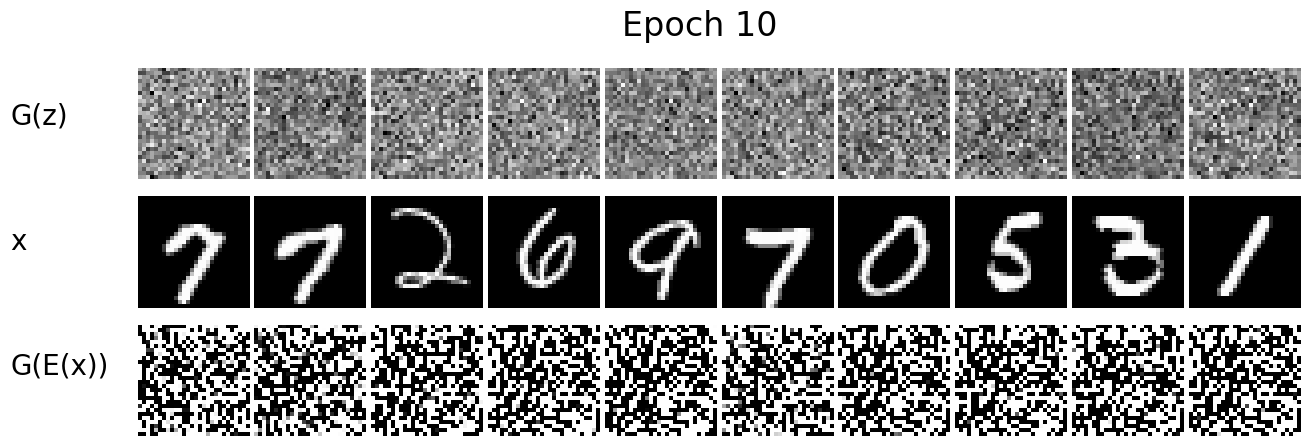

In [ ]:
          D.eval()
          E.eval()
          G.eval()
          n_show =10
          with torch.no_grad():
              real = images[:n_show]
              z = 2 * torch.rand(n_show, 50) - 1
              z = z.to(device)
              gener = G(z).reshape(n_show, 28, 28).cpu().numpy()
              recon = G(E(real)).reshape(n_show, 28, 28).cpu().numpy()
              real = real.reshape(n_show, 28, 28).cpu().numpy()

              fig, ax = plt.subplots(3, n_show, figsize=(15,5))
              fig.subplots_adjust(wspace=0.05, hspace=0)
              plt.rcParams.update({'font.size': 20})
              fig.suptitle('Epoch {}'.format(epoch+1))
              fig.text(0.04, 0.75, 'G(z)', ha='left')
              fig.text(0.04, 0.5, 'x', ha='left')
              fig.text(0.04, 0.25, 'G(E(x))', ha='left')

              for i in range(n_show):
                  ax[0, i].imshow(gener[i], cmap='gray')
                  ax[0, i].axis('off')
                  ax[1, i].imshow(real[i], cmap='gray')
                  ax[1, i].axis('off')
                  ax[2, i].imshow(recon[i], cmap='gray')
                  ax[2, i].axis('off')
              plt.show()

In [ ]:
def generate_digit(generator, digit):
    z = torch.randn(1, 100).to(device)
    label = torch.LongTensor([digit]).to(device)
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)